In [146]:
import pandas as pd
import numpy as np
import xgboost as xgb
import itertools
import pickle
import matplotlib
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score, roc_curve, auc
from scipy import interp
from itertools import cycle

# matplotlib.rcParams.update({'font.size': 14})
%matplotlib inline

/home/maria/Programs/anaconda3/lib/python3.6/site-packages/matplotlib/backends/__init__.py:60: MatplotlibDeprecationWarning: matplotlib.verbose is deprecated;
Command line argument --verbose-LEVEL is deprecated.
This functionality is now provided by the standard
python logging library.  To get more (or less) logging output:
    import logging
    logger = logging.getLogger('matplotlib')
    logger.set_level(logging.INFO)
  # imports. 0 means only perform absolute imports.
/home/maria/Programs/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:356: MatplotlibDeprecationWarning: matplotlib.verbose is deprecated;
Command line argument --verbose-LEVEL is deprecated.
This functionality is now provided by the standard
python logging library.  To get more (or less) logging output:
    import logging
    logger = logging.getLogger('matplotlib')
    logger.set_level(logging.INFO)
  if self.ge(level):


In [155]:
df = pd.read_csv('extracted_features/df_features_pca.csv')
print(df.shape)
df.head()

(4560, 61)


,file_name,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,...,pca_51,pca_52,pca_53,pca_54,pca_55,pca_56,pca_57,pca_58,pca_59,pca_60
0,22564_Wedding_music.wav,-638.283743,797.760300,-104.791661,-40.640350,43.685622,-21.852234,-97.658862,4.003027,-15.659688,...,1.120721,-0.628025,-1.298481,2.057688,1.017574,-0.481963,-0.161318,1.264022,-0.325472,0.320518
1,2170_Wedding_music.wav,-2252.688348,-223.837713,-131.680587,45.288983,77.990478,69.176620,-21.222539,9.563729,0.438047,...,1.205281,0.327043,-0.350518,0.075465,1.139012,0.180213,0.831102,0.632054,0.390715,0.818182
2,12235_Dance_music.wav,2038.545816,116.487616,-172.756628,-79.590050,-60.919398,-83.415731,-113.587213,-30.380727,0.173788,...,1.316422,-0.140328,0.592188,0.786408,0.650101,0.170685,-1.026900,-0.299049,0.650272,-0.025711
3,4743_Dance_music.wav,1656.999493,-114.807179,33.856087,-60.341633,-60.823697,56.789022,50.566851,16.062891,-2.680556,...,0.572856,-0.605472,-1.419425,1.298980,0.432158,0.508419,-0.178374,-0.162710,0.476347,-0.369380
4,17151_Wedding_music.wav,-1891.144495,-916.624239,195.197957,-12.865184,46.986571,110.621889,-44.145420,24.258285,43.876532,...,0.600837,-0.756884,0.671616,-0.643474,-1.840740,0.671540,-0.232468,-0.040159,0.636269,-0.211106


In [156]:
label_dict = {  'Background_music':0,
                'Theme_music':1,
                'Jingle':2,
                'Soundtrack_music':3,
                'Lullaby':4,
                'Video_game_music':5,
                'Christmas_music':6,
                'Dance_music':7,
                'Wedding_music':8}
                # 'Birthday_music':9} 

# Normalization of the features
scalar = MinMaxScaler()
df[df.columns[1:]] = scalar.fit_transform(df[df.columns[1:]])
df['label'] = df['file_name'].apply(lambda x: label_dict[x[:-4].split('_', 1)[1]])
df.head()

TypeError: 'float' object is not subscriptable

In [149]:
# Train-test split of files # Same split as used for VGG model
x_train, x_test, y_train, y_test = train_test_split(df[df.columns[1:-1]], 
                                                    df['label'],
                                                    random_state = 10, 
                                                    test_size = 0.2
                                                    )

# Among the test files, keep half for validation
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test,
                                                random_state = 10, 
                                                test_size = 0.5
                                                )


In [150]:
experiment_path = 'pca/'
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(15,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.savefig('plots/' + experiment_path + title.replace(" ", "_") +'.png', bbox_inches='tight')
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_results(y_test, pred_probs, cm = True, cm_title='Confustion matrix'):
    pred = np.argmax(pred_probs, axis=-1)
    one_hot_true = one_hot_encoder(y_test, len(pred), len(label_dict))
    print('Accuracy =  {0:.2f}'.format(accuracy_score(y_test, pred)))
    print('F-score =  {0:.2f}'.format(f1_score(y_test, pred, average='macro')))
    print('ROC AUC = {0:.3f}'.format(roc_auc_score(y_true=one_hot_true, y_score=pred_probs, average='macro')))
    if cm:
        roles = ['Background', 'Theme', 'Jingle', 'Soundtrack', 'Lullaby', 'Video_game', 'Christmas',
        'Dance', 'Wedding']#, 'Birthday'] # for beatiful plotting
        plot_confusion_matrix(confusion_matrix(y_test[:len(pred)], pred), classes=roles, title=cm_title)

### Logistic Regression
LR is usually done for binary classification tasks. For this multi-class classification task, the LR is implemented as a one-vs-rest method. That is, 7 separate classifiers are trained. During test time, the class with the highest prob. from among the 7 classifiers is the predicted class.

Accuracy =  0.38
F-score =  0.34
ROC AUC = 0.777
Confusion matrix, without normalization
[[ 7 13  3  4  7  8  3  7 10]
 [ 4 11  6  7  4  8  2  5  5]
 [ 0  1 12  2  3  4 10 11  3]
 [ 2  9  2  7  5 10  1 15  3]
 [ 2  2  1  2 47  2  6  1  7]
 [ 0  5  3  5  2 21  1  6  2]
 [ 3  1 10  1  7  5 14 10  4]
 [ 1  3  6  1  1  3  0 44  3]
 [ 2  6  4  1 10  1  6  4 32]]
CPU times: user 484 ms, sys: 0 ns, total: 484 ms
Wall time: 481 ms


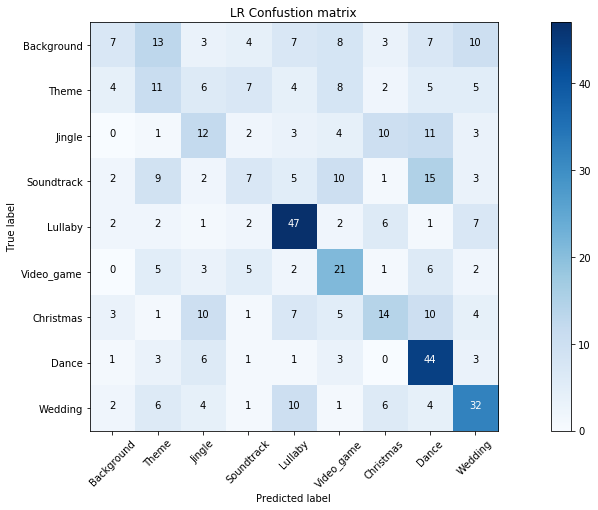

In [151]:
%%time
# Train
lr_classifier = LogisticRegression(penalty='l2')
lr_classifier.fit(x_train, y_train)

# Prediction for validation set 
pred_probs = lr_classifier.predict_proba(x_val)
display_results(y_val, pred_probs, cm_title='LR Confustion matrix')
# Save
with open('pred_probas/lr_classifier_val.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)
    
# Prediction for test set
pred_probs_LR = lr_classifier.predict_proba(x_test)
# Save
with open('pred_probas/lr_classifier_test.pkl', 'wb') as f:
    pickle.dump(pred_probs_LR, f)

### Random Forest

Accuracy =  0.41
F-score =  0.38
ROC AUC = 0.786
Confusion matrix, without normalization
[[ 8 12  9  2  8  7  1  5 10]
 [ 7 12  4  4  2  8  3 10  2]
 [ 2  0 18  1  5  2  4  9  5]
 [ 5 11  3  7  7  4  1 15  1]
 [ 3  0  2  0 55  0  4  0  6]
 [ 4  4  3  5  1 21  0  4  3]
 [ 3  1  8  1  9  1 18  7  7]
 [ 0  2  5  2  2  6  0 41  4]
 [ 2  5  1  1 16  2  5  2 32]]
CPU times: user 9.33 s, sys: 7.97 ms, total: 9.33 s
Wall time: 9.33 s


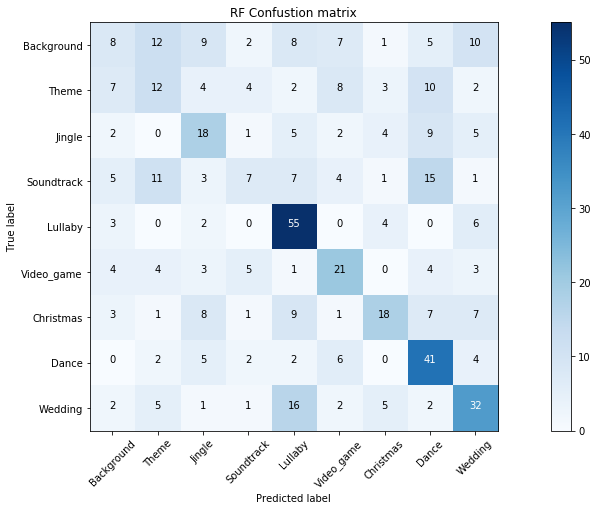

In [152]:
%%time
# Train
rf_classifier = RandomForestClassifier(n_estimators=500, min_samples_split=5)
rf_classifier.fit(x_train, y_train)

# Predict (validation set)
pred_probs = rf_classifier.predict_proba(x_val)
display_results(y_val, pred_probs, cm_title='RF Confustion matrix')

# Save
with open('pred_probas/rf_classifier_val.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)
    
# Prediction for test set
pred_probs_RF = rf_classifier.predict_proba(x_test)
# Save
with open('pred_probas/rf_classifier_test.pkl', 'wb') as f:
    pickle.dump(pred_probs_RF, f)

### Gradient Boosting 

Accuracy =  0.41
F-score =  0.39
ROC AUC = 0.793
Confusion matrix, without normalization
[[12 12  5  5  5  8  2  4  9]
 [ 7 12  5 10  3  8  2  3  2]
 [ 3  1 16  4  2  3  6  8  3]
 [ 5  7  6 14  1  7  4  9  1]
 [ 2  3  2  0 49  0  3  1 10]
 [ 7  6  1  8  1 18  2  1  1]
 [ 4  1  6  1  5  0 24  8  6]
 [ 3  3  6  5  1  5  3 32  4]
 [ 6  2  0  5 12  2  4  3 32]]
CPU times: user 1min 14s, sys: 63.8 ms, total: 1min 14s
Wall time: 1min 14s


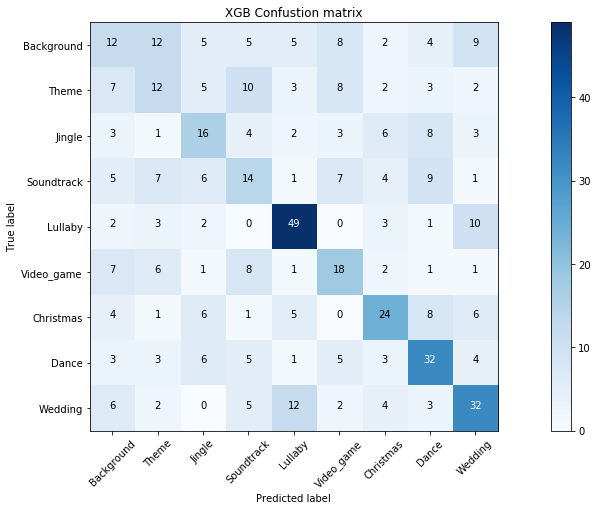

In [153]:
%%time
# Train
xgb_classifier = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, objective='multi:softprob', 
                                   n_estimators=500, sub_sample = 0.8, num_class = len(label_dict))
xgb_classifier.fit(x_train, y_train)

# Prediction and result (validation set)
pred_probs = xgb_classifier.predict_proba(x_val)
display_results(y_val, pred_probs, cm_title='XGB Confustion matrix')

# Save
with open('pred_probas/xgb_classifier_val.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)
        
# Prediction for test set
pred_probs_XGB = xgb_classifier.predict_proba(x_test)
# Save
with open('pred_probas/xgb_classifier_test.pkl', 'wb') as f:
    pickle.dump(pred_probs_XGB, f)

### Support Vector Machines

Accuracy =  0.42
F-score =  0.39
ROC AUC = 0.801
Confusion matrix, without normalization
[[11 12  6  4  6  6  3  6  8]
 [ 6 11  3  8  2 11  3  5  3]
 [ 3  1 14  4  1  4  9  8  2]
 [ 2  9  2 12  5 10  2 11  1]
 [ 2  2  1  1 50  0  5  0  9]
 [ 1  4  4  6  1 23  1  4  1]
 [ 4  2 12  2  4  1 18  6  6]
 [ 1  3  1  6  0  5  1 39  6]
 [ 3  3  3  1 10  5  3  1 37]]
CPU times: user 30.9 s, sys: 31.9 ms, total: 31 s
Wall time: 31 s


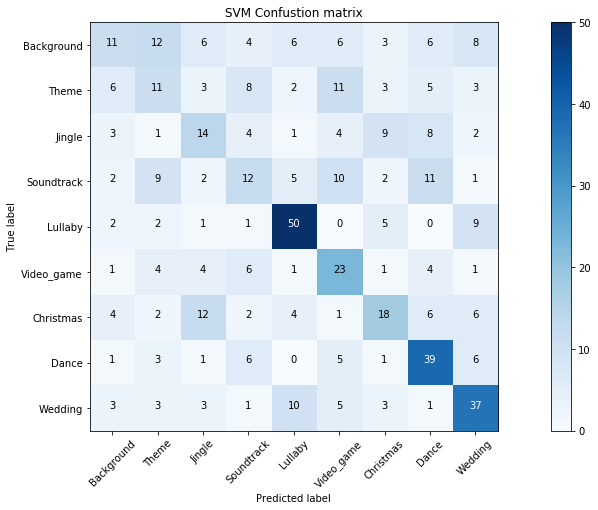

In [154]:
%%time
# Train
svm_classifier = SVC(C=10000.0, probability = True, kernel='rbf') # class_weight=cl_weight,
svm_classifier.fit(x_train, y_train)

# Predict (validation set)
pred_probs = svm_classifier.predict_proba(x_val)

# Results
display_results(y_val, pred_probs, cm_title='SVM Confustion matrix')

# Save
with open('pred_probas/svm_classifier_val.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)
        
# Prediction for test set
pred_probs_SVM = svm_classifier.predict_proba(x_test)
# Save
with open('pred_probas/svm_classifier_test.pkl', 'wb') as f:
    pickle.dump(pred_probs_SVM, f)

### Most Important Feature
Determine the features that contribute the most towards making the correct classfication

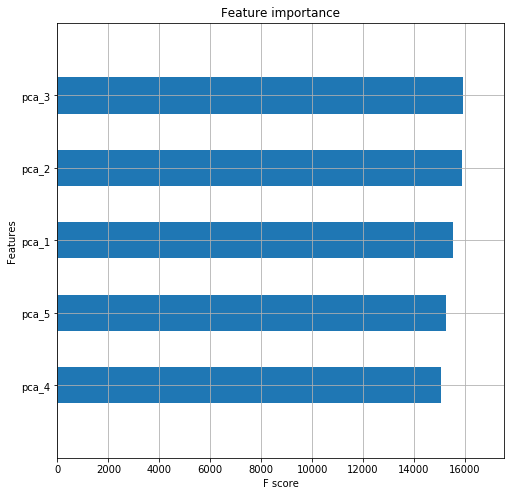

In [99]:
ax = xgb.plot_importance(xgb_classifier, max_num_features=20, height=0.5, show_values=False)
fig = ax.figure
fig.set_size_inches(8, 8)
# plt.savefig('plots/feature-imp.png', bbox_inches='tight')

The most important features seem to be MFCCs and spectral contrast (mean and std dev in different frequency bins). Use the top N features, build the model and look at the metrics

In [100]:
contribution_scores = xgb_classifier.feature_importances_
contribution_scores

array([0.2001467 , 0.20435476, 0.20508827, 0.19380245, 0.19660781],
      dtype=float32)

In [136]:
#top_n = [5, 10, 20, 30, 50]
top_n = [50, 60, 70, 80, 90]
for n in top_n:
    threshold = np.argsort(contribution_scores)[::-1][:n][-1]
    print('Stats for top {} pca features:'.format(n))
    # Select features using threshold
    #selection = SelectFromModel(xgb_classifier, threshold=contribution_scores[threshold], prefit=True)
    #select_x_train = selection.transform(x_train)
    #select_x_val = selection.transform(x_val)
    select_x_train = x_train.iloc[:, :n]
    select_x_val = x_val.iloc[:, :n]
    
    # Train
    #select_xgb_classifier = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, objective='multi:softprob', 
                                       #n_estimators=500, sub_sample = 0.8, num_class = len(label_dict))
    #select_xgb_classifier.fit(select_x_train, y_train)
    svm_classifier = SVC(C=10000.0, probability = True, kernel='rbf') # class_weight=cl_weight,
    svm_classifier.fit(select_x_train, y_train)
    pred_probs = svm_classifier.predict_proba(select_x_val)

    # Predict
    #pred_probs = select_xgb_classifier.predict_proba(select_x_val)

    # Results
    display_results(y_val, pred_probs, cm = False)     
    print()

Stats for top 50 pca features:
Test Set Accuracy =  0.41
Test Set F-score =  0.38
ROC AUC = 0.801

Stats for top 60 pca features:
Test Set Accuracy =  0.42
Test Set F-score =  0.40
ROC AUC = 0.801

Stats for top 70 pca features:
Test Set Accuracy =  0.41
Test Set F-score =  0.38
ROC AUC = 0.799

Stats for top 80 pca features:
Test Set Accuracy =  0.39
Test Set F-score =  0.36
ROC AUC = 0.799

Stats for top 90 pca features:
Test Set Accuracy =  0.40
Test Set F-score =  0.38
ROC AUC = 0.798



### Ensemble of XGB and VGG

In [61]:
# Load predicted probabilities
with open('pred_probas/xgb_classifier.pkl', 'rb') as f:
    xgb_pred_probs = pickle.load(f)
    
with open('pred_probas/vgg_fine_tuning.pkl', 'rb') as f:
    vgg_pred_probs = pickle.load(f)
    
n_samples = np.min([len(xgb_pred_probs), len(vgg_pred_probs)])

# Average of the predicted probabilites
ensemble_pred_probs = (xgb_pred_probs[:n_samples] + vgg_pred_probs[:n_samples])/2.0

# Show metrics
display_results(y_test[:n_samples], ensemble_pred_probs)

ValueError: operands could not be broadcast together with shapes (514,9) (514,7) 

### Plot 3 ROCs the same graph
- VGG
- XGB
- Ensemble

In [8]:
# Compute macro-average ROC curve and ROC area
# Compute ROC curve and ROC area for each class

def plot_roc_curves(y_true, pred_probs, label_dict):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    NUM_CLASSES = len(label_dict)
    one_hot_true = one_hot_encoder(y_true, len(y_true), NUM_CLASSES)
    for i in range(len(label_dict)):
        fpr[i], tpr[i], _ = roc_curve(one_hot_true[:, i], pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])    

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(NUM_CLASSES)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(NUM_CLASSES):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= NUM_CLASSES

    return all_fpr, mean_tpr, auc(all_fpr, mean_tpr)

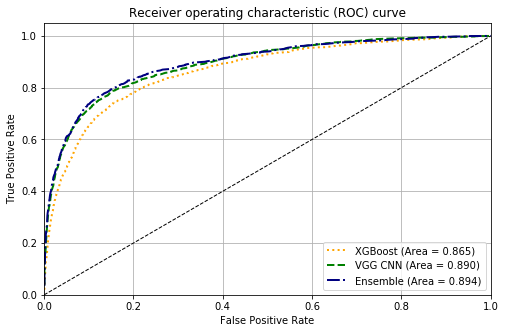

In [9]:
# Plot all ROC curves
plt.figure(figsize=(8,5))

plt.title('Macro-average ROC curves')

fpr, tpr, roc_auc = plot_roc_curves(y_test[:n_samples], xgb_pred_probs[:n_samples], label_dict)
plt.plot(fpr, tpr,
         label='XGBoost (Area = {0:0.3f})'
               ''.format(roc_auc),
         color='orange', linestyle=':', linewidth=2)

fpr, tpr, roc_auc = plot_roc_curves(y_test[:n_samples], vgg_pred_probs[:n_samples], label_dict)
plt.plot(fpr, tpr,
         label='VGG CNN (Area = {0:0.3f})'
               ''.format(roc_auc),
         color='green', linestyle='--', linewidth=2)

fpr, tpr, roc_auc = plot_roc_curves(y_test[:n_samples], ensemble_pred_probs[:n_samples]
                                    , label_dict)
plt.plot(fpr, tpr,
         label='Ensemble (Area = {0:0.3f})'
               ''.format(roc_auc),
         color='navy', linestyle='-.', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.grid()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
# plt.savefig('plots/roc-curve.png')
plt.show()

#### Time Domain Feature Only

Test Set Accuracy =  0.40
Test Set F-score =  0.34
ROC AUC = 0.731
Confusion matrix, without normalization
[[183  60   8  16  10  34  53]
 [ 59 143  17  12   8 106  38]
 [ 24  32  56   4   2  33  20]
 [ 78  47  12  10  13  41  31]
 [ 40  35   5   5  20  13  14]
 [ 27  70  10   7   7 252  43]
 [ 48  53  12   9   8  62 137]]
CPU times: user 1min 23s, sys: 16.1 ms, total: 1min 23s
Wall time: 1min 23s


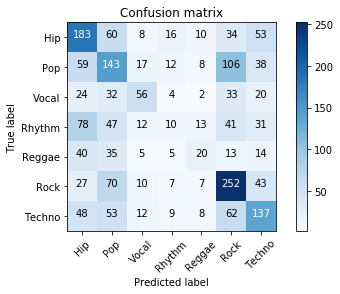

In [14]:
%%time
# Train
xgb_classifier = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, objective='multi:softprob', 
                                   n_estimators=500, sub_sample = 0.8, num_class = len(label_dict))
xgb_classifier.fit(x_train.iloc[:,:9], y_train)

# Predict
pred_probs = xgb_classifier.predict_proba(x_test.iloc[:,:9])

# Results
display_results(y_test, pred_probs)

# Save
with open('pred_probas/xgb_classifier_time_domain.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

#### Frequency Domain Feature Only

Test Set Accuracy =  0.57
Test Set F-score =  0.53
ROC AUC = 0.857
Confusion matrix, without normalization
[[230  55  10  14  16  14  25]
 [ 55 203  18  19   6  52  30]
 [ 12  11 106   6   4  18  14]
 [ 44  62   5  46  19  31  25]
 [ 25  32   5  14  43   8   5]
 [ 13  50   8   5   1 317  22]
 [ 23  31  11   7   3  51 203]]
CPU times: user 17min 8s, sys: 28 ms, total: 17min 8s
Wall time: 17min 8s


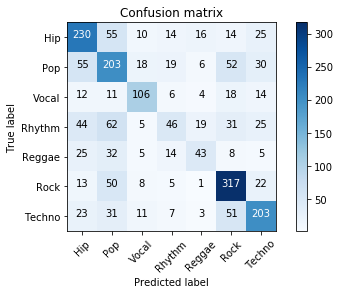

In [15]:
%%time
# Train
xgb_classifier = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, objective='multi:softprob', 
                                   n_estimators=500, sub_sample = 0.8, num_class = len(label_dict))
xgb_classifier.fit(x_train.iloc[:,9:], y_train)

# Predict
pred_probs = xgb_classifier.predict_proba(x_test.iloc[:,9:])

# Results
display_results(y_test, pred_probs)

# Save
with open('pred_probas/xgb_classifier_freq_domain.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)